## Libraries

In [125]:
# Core Libraries
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore

# Dimensionality Reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# UMAP (optional – requires pip install umap-learn)
import umap

# Clustering
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram

# Anomaly Detection
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor


# Utility / Settings
import warnings

## 1. Data Wrangling

**Objective:** We want to convert  the raw biochemical patient data into a structured feature matrix on which we can perform geometric and statistical modeling.

* Removed patient ID to avoid artificial structure.
* Audited and corrected variable types to prevent parsing errors and preserve numerical precision.
* Assessed missingness to reduce bias in structure estimation:

  * Excluded records with >30% missing values.
  * Applied **median imputation (numerical)** and **most-frequent imputation (categorical)** to preserve distributional robustness.
* Enforced biological plausibility constraints (valid age range and non-negative lab values) to prevent clustering artifacts from erroneous entries.
* Encoded categorical variables for compatibility with numerical algorithms
* Separated the categories from the rest of the data





In [126]:
# -----------------------------
# Load data
# -----------------------------
df = pd.read_csv("HepatitisCdata.csv")
#df.head()

In [127]:
# -----------------------------
# Remove non-informative columns
# -----------------------------
df = df.drop(columns=["Unnamed: 0"])
#df.head()

In [128]:
# -----------------------------
# Verify and enforce data types
# -----------------------------
categorical_cols = ["Sex", "Category"]
numeric_cols = [c for c in df.columns if c not in categorical_cols]

# Convert numeric columns safely
for c in numeric_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")


In [129]:
# -----------------------------
# Handle Missing Values
# -----------------------------

# Step 1: Remove rows with excessive missingness (>30%)
row_missing_fraction = df.isna().mean(axis=1)
df = df.loc[row_missing_fraction <= 0.30].copy()

# Step 2: Impute remaining missing values
num_imputer = SimpleImputer(strategy="median")
cat_imputer = SimpleImputer(strategy="most_frequent")

df[numeric_cols] = num_imputer.fit_transform(df[numeric_cols])
df[["Sex"]] = cat_imputer.fit_transform(df[["Sex"]])


In [130]:
# -----------------------------
# Remove biologically impossible values
# -----------------------------

# Age constraints
if "Age" in df.columns:
    df = df[(df["Age"] > 0) & (df["Age"] < 120)].copy()

# Lab marker (non-negative)
lab_markers = ["ALB","ALP","ALT","AST","BIL","CHE","CHOL","CREA","GGT","PROT"]
lab_markers = [c for c in lab_markers if c in df.columns]

for c in lab_markers:
    df = df[df[c] >= 0].copy()


In [131]:
# -----------------------------
# Encode categorical variables
# -----------------------------
sex_map = {"m": 1, "M": 1, "male": 1, "Male": 1,
           "f": 0, "F": 0, "female": 0, "Female": 0}

df["Sex_bin"] = df["Sex"].map(sex_map)

# Robust fillna: if mode is empty (all NaN), fallback to 0
mode_series = df["Sex_bin"].mode(dropna=True)
fill_value = int(mode_series.iloc[0]) if not mode_series.empty else 0
df["Sex_bin"] = df["Sex_bin"].fillna(fill_value).astype(int)



In [132]:
# -----------------------------
# FEATURE MATRIX
# -----------------------------

# Keep Category for post interpretation
y_category = df["Category"].copy()

# Build feature matrix X (exclude Category and original Sex)
feature_cols = ["Age", "Sex_bin"] + lab_markers
X = df[feature_cols].copy()

# Standardize all features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=feature_cols, index=df.index)
#print(X_scaled.mean())
#print(X_scaled.std())

print("X_scaled shape:", X_scaled.shape)
print("Unique categories:", sorted(pd.unique(y_category)))
#X.head()


X_scaled shape: (615, 12)
Unique categories: ['0=Blood Donor', '0s=suspect Blood Donor', '1=Hepatitis', '2=Fibrosis', '3=Cirrhosis']


In [133]:
# -----------------------------
# LOG-TRANSFORMATION
# -----------------------------
# Skewed variables in this dataset, noticed in 2.1 distributional analysis
skewed_vars = [c for c in ["ALT", "AST", "GGT", "BIL", "CREA"] if c in df.columns]
print("\nSkewed variables to log transform:", skewed_vars)

# Log-transform skewed variables
for c in skewed_vars:
    if c in X.columns:
        X[c] = np.log1p(X[c])


Skewed variables to log transform: ['ALT', 'AST', 'GGT', 'BIL', 'CREA']


## 2. Exploratory Data Analysis (EDA)


### 2.1 Distribution Analysis
**Objective** : We want to identify skewness and potential heavy tails and will make log transformation in Data Wrangling section where apropriate.

**Observations** :
* CREA, BIL, GGT, ALT, AST exhibit strong positive skewness.Meaning thier upper quantiles (95th–99th) are substantially higher than median values, this indicates a heavy right tails.
* For this fact we consider logarithmic transformation before applying distance-based models.


In [134]:
# -----------------------------
# 2.1 Distribution Analysis
# -----------------------------

# Identify skewness of each numeric variable
skewness = df[numeric_cols].skew(numeric_only=True).sort_values(ascending=False)
print("\nSkewness (descending):\n", skewness)

# Skewed variables in this dataset
# done in Data Wrangling
print("\nSkewed variables to log transform:", skewed_vars)

#Quantiles to see outliers
print("\nQuantiles for skewed vars:")
print(df[skewed_vars].quantile([0.5, 0.75, 0.9, 0.95, 0.99]))



Skewness (descending):
 CREA    15.169291
BIL      8.385437
GGT      5.632734
ALT      5.510989
AST      4.940327
ALP      4.730036
CHOL     0.381835
Age      0.267134
CHE     -0.110233
ALB     -0.177189
PROT    -0.964607
dtype: float64

Skewed variables to log transform: ['ALT', 'AST', 'GGT', 'BIL', 'CREA']

Quantiles for skewed vars:
          ALT      AST      GGT    BIL     CREA
0.50   23.000   25.900   23.300   7.30   77.000
0.75   33.050   32.900   40.200  11.20   88.000
0.90   46.700   52.480   77.300  18.00   99.000
0.95   62.030   91.840  108.500  24.03  106.000
0.99  118.086  187.322  292.534  87.64  134.826


### 2.2 Summary statistics
**Objective** :
 * We want to understand the quantitative baseline for each feature before modeling.
 * We want to examin summary statistics such as mean, standard deviation, minimum, and maximum values. Also we want to look at robust statistics such as median and interquartile range (IQR)
 * We'll also assess overall central tendency, dispersion, and potential extreme values within the dataset.
* The main objective is understand the data structure before we apply unsupervised learning techniques.


**Observations** :
*  For ALT, AST, BIL, GGT,CREA, the mean exceeds the median and the maximum values are disproportionately large relative to the IQR, this shows yes again the presence of extreme upper-tail observations.
* For ALB, CHOL, PROT, and Age we observe a relatively symmetric distributions with moderate dispersion.

In [135]:
# -----------------------------
# 2.2 Summary statistics
# -----------------------------
print("\n--- Summary statistics (features only) ---")
print(X.describe().T)

print("\n--- Robust stats (median + IQR) ---")
median = X.median(numeric_only=True)
q1 = X.quantile(0.25, numeric_only=True)
q3 = X.quantile(0.75, numeric_only=True)
iqr = q3 - q1
robust_stats = pd.DataFrame({"Q1": q1, "median": median, "Q3": q3, "IQR": iqr})
print(robust_stats)


--- Summary statistics (features only) ---
         count       mean        std        min        25%        50%  \
Age      615.0  47.408130  10.055105  19.000000  39.000000  47.000000   
Sex_bin  615.0   0.613008   0.487458   0.000000   0.000000   1.000000   
ALB      615.0  41.620732   5.775935  14.900000  38.800000  41.950000   
ALP      615.0  68.222927  25.646364  11.300000  52.950000  66.200000   
ALT      615.0   3.181725   0.614934   0.641854   2.856470   3.178054   
AST      615.0   3.405217   0.491600   2.451005   3.117950   3.292126   
BIL      615.0   2.218744   0.627274   0.587787   1.840550   2.116256   
CHE      615.0   8.196634   2.205657   1.420000   6.935000   8.260000   
CHOL     615.0   5.366992   1.123499   1.430000   4.620000   5.300000   
CREA     615.0   4.359903   0.275590   2.197225   4.219508   4.356709   
GGT      615.0   3.341741   0.742901   1.704748   2.815409   3.190476   
PROT     615.0  72.044390   5.398238  44.800000  69.300000  72.200000   

      

### 2.3 Correlation between Features

**Objective** :
* Examine linear relationships between biochemical markers to detect redundancy and structural dependencies in the dataset.
*  By computing the correlation matrix and identifying the strongest absolute correlations, we assess which variables convey overlapping information. Such as expected relationships between liver enzymes (ALT and AST) or between albumin and total protein
* Assess potential multicollinearity which can inflate dimensionality without adding independent information, which can bias distance-based algorithms.
* The heatmap provides a visual representation of these correlation patterns
* The main objective is to justifies the use of dimensionality reduction techniques.

**Observations Correlation matrix** :
* Moderate correlations are present but no extreme multicollinearity (no |r| > 0.7).
* The correlation matrix reveals linear relationships between several biochemical markers.
* Strongest correlation: **ALB–PROT (r ≈ 0.55)** - clinically coherentsince albumin constitutes a major fraction of total protein.
* Liver injury markers also show structural coupling, **AST–GGT (r ≈ 0.49)** and **ALP–GGT (r ≈ 0.44)**, suggesting partially shared inflammatory or cholestatic processes.
* Metabolic markers such as **CHE–CHOL (r ≈ 0.42)** also exhibit moderate correlation, reflecting related hepatic synthetic functions.
* Conclucion : Presence of several moderate correlations shows partial redundancy within the feature space. Thus we can justify the use of dimensionality reduction techniques to compress correlated information into latent components while preserving the biological structure.

**Observations Correlation Heatmap** :

* Visual blocks confirm moderate positive correlations among liver enzymes.
* Clear grouping between ALB–PROT and CHE–CHOL.
* No deep red blocks, absence of severe multicollinearity.
* Feature space shows structured physiological relationships rather than independence.



--- Top absolute correlations (excluding self-correlations) ---
AST      GGT     0.557091
ALB      PROT    0.549975
AST      BIL     0.442286
CHE      CHOL    0.420215
ALB      CHE     0.375817
Sex_bin  CREA    0.318524
ALT      CHE     0.316859
CHE      PROT    0.293041
ALT      GGT     0.280237
BIL      GGT     0.276495
ALP      GGT     0.272101
Sex_bin  GGT     0.270872
ALT      AST     0.257557
BIL      CHE     0.252557
Sex_bin  ALT     0.242398
dtype: float64


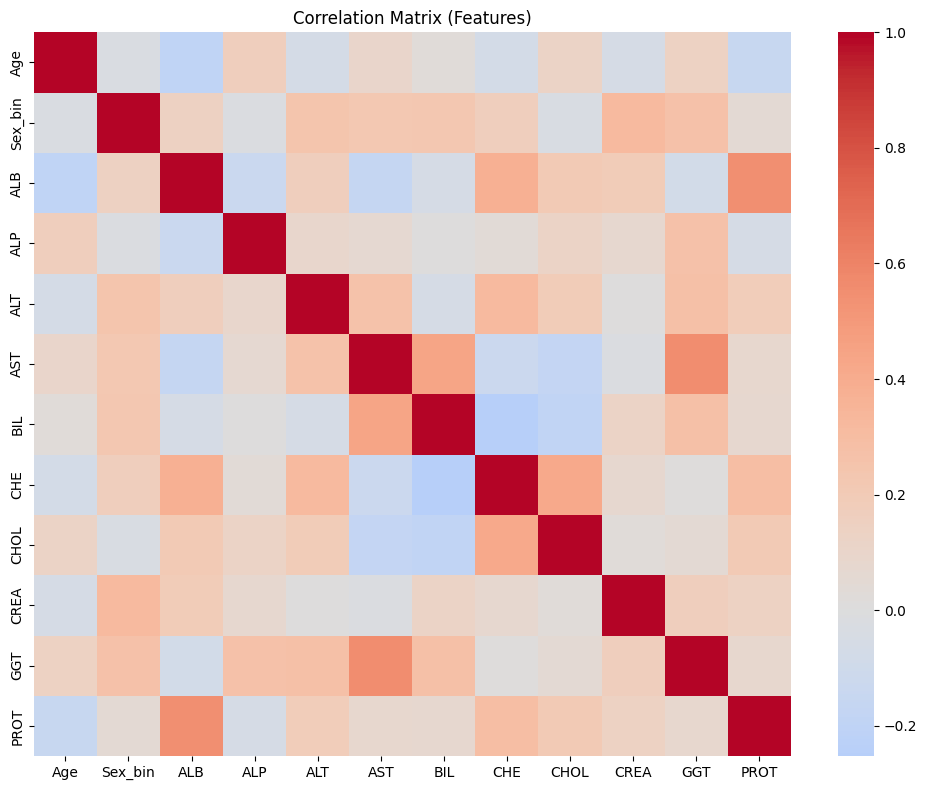

In [136]:
# -----------------------------
# 2.3.a Correlation matrix (redundancy detection)
# -----------------------------
corr = X.corr(numeric_only=True)

print("\n--- Top absolute correlations (excluding self-correlations) ---")
corr_abs = corr.abs()
upper = corr_abs.where(np.triu(np.ones(corr_abs.shape), k=1).astype(bool))
top_pairs = upper.stack().sort_values(ascending=False).head(15)
print(top_pairs)

# -----------------------------
# 2.3.b Correlation Heatmap
# -----------------------------
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
plt.title("Correlation Matrix (Features)")
plt.tight_layout()
plt.show()


### 2.4 Variance Check
**Objective** :
Detect features with very low variance that may add little information to clustering.

**Observations**:
* All variables contribute meaningful variability.
* High variance in ALT, AST, GGT, CREA  shows wide biological spread


In [137]:
# -----------------------------
# 2.4 Variance Check
# -----------------------------
variance = X.var(numeric_only=True).sort_values()

print("\nFeature variances (ascending):")
print(variance)

#Low variance features
low_variance = variance[variance < 0.01]
print("\nPotential low-variance features:")
print(low_variance)


Feature variances (ascending):
CREA         0.075950
Sex_bin      0.237616
AST          0.241671
ALT          0.378143
BIL          0.393473
GGT          0.551902
CHOL         1.262251
CHE          4.864924
PROT        29.140974
ALB         33.361430
Age        101.105146
ALP        657.736004
dtype: float64

Potential low-variance features:
Series([], dtype: float64)



### 2.5  Pairwise plots
**Objective** :
We want to visually assess relationships between selected biomarkers to confirm correlation patterns, detect potential outliers, and identify geometric structure before applying dimensionality reduction and clustering.

**Observations**:
* ALT, AST, BIL, GGT, and CREA show strong right-skew with long upper tails.
* ALB, PROT, and Age appear more symmetric and concentrated.
* CREA and GGT display extreme upper outliers.
* Clear positive relationship between **ALT and AST** - expected clinical coupling.
* Moderate association between **AST and GGT** and **ALP and GGT** (consistent with hepatobiliary involvement).
* Relationships appear roughly linear but with high dispersion at extreme values.
* Strong linear trend between **ALB and PROT**, confirming redundancy. Tight clustering suggests stable physiological linkage.
* Several extreme points in GGT and CREA extend far beyond the main cloud. - solved by log transformation
* No clearly separated visible clusters.
* Suggests disease progression may form a continuum rather than sharply separated groups.






Pairplot variables used: ['Age', 'ALB', 'PROT', 'ALT', 'AST', 'BIL', 'GGT', 'CREA']


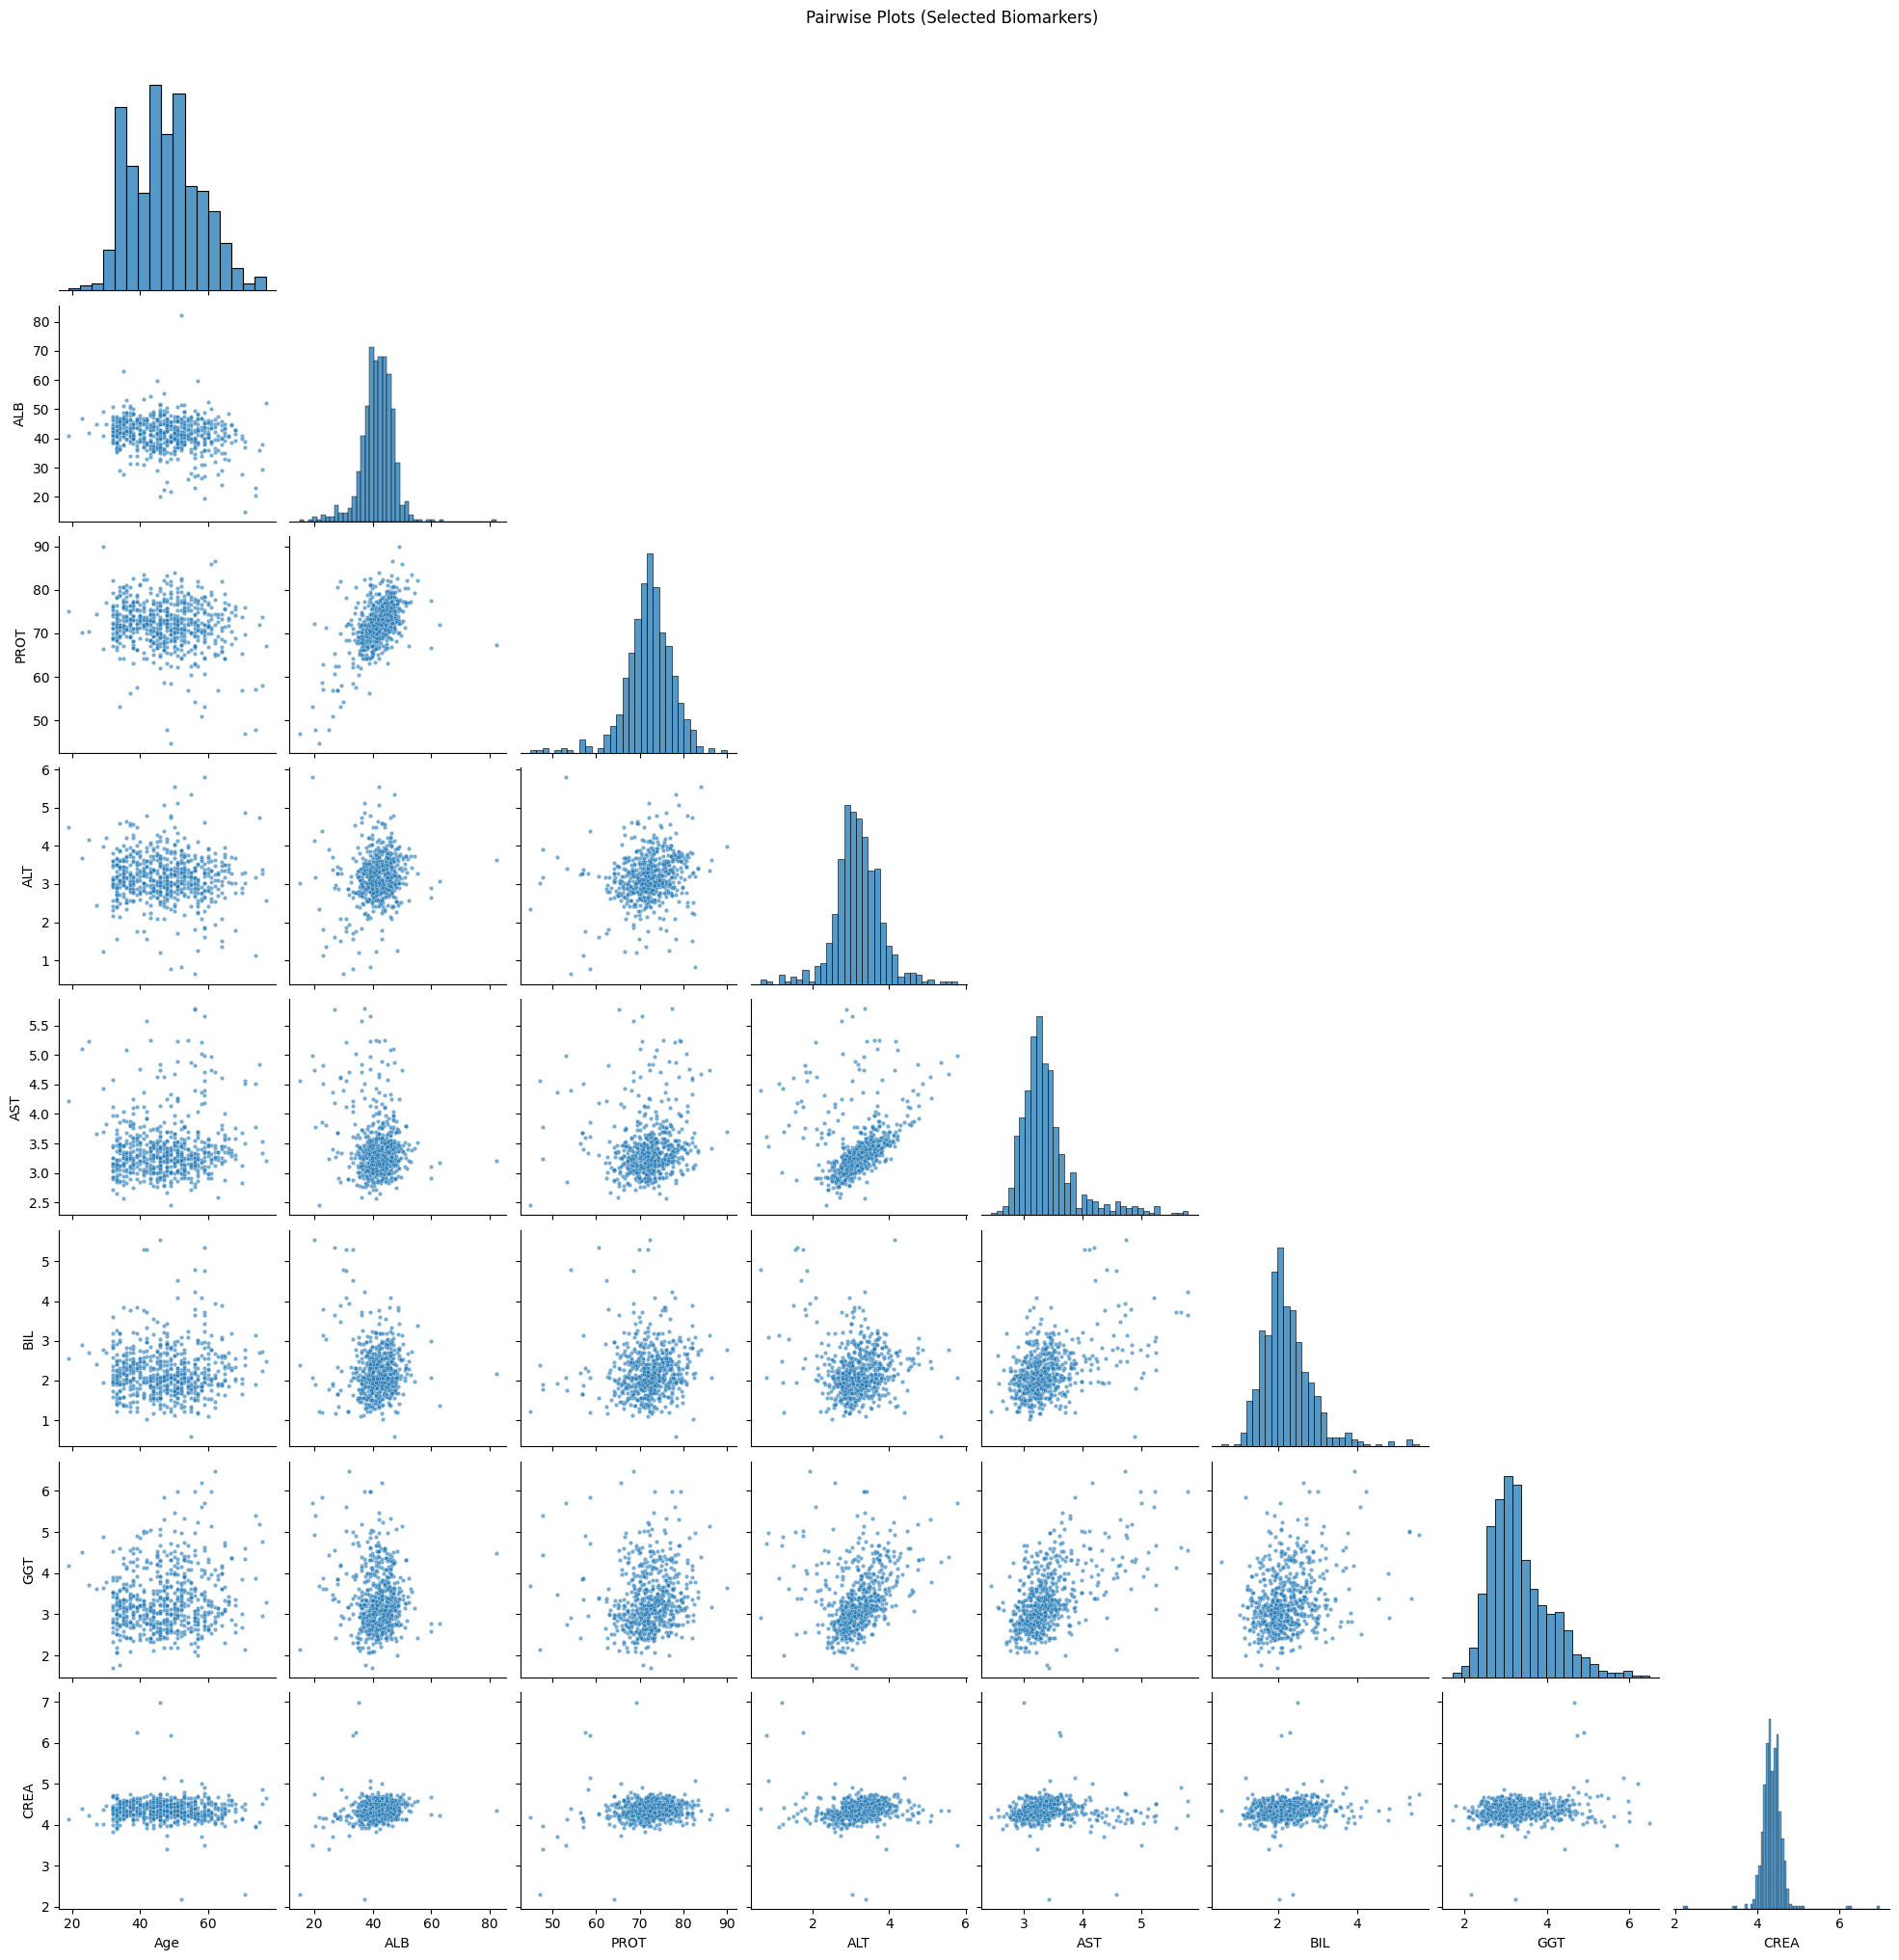

In [138]:
# -----------------------------
# 2.5 Pairwise plots
# -----------------------------
selected = [c for c in ["Age", "ALB", "PROT", "ALT", "AST", "BIL", "GGT", "CREA"] if c in X.columns]

print("\nPairplot variables used:", selected)

sns.pairplot(X[selected], corner=True, plot_kws={"s": 10, "alpha": 0.6})
plt.suptitle("Pairwise Plots (Selected Biomarkers)", y=1.02)
plt.show()



### 2.6 Early anomaly detection
**Objective** :
The objective of this step is to identify extreme upper-tail observations by counting values above the 99th percentile for selected biomarkers..

**Observations**:
 * Each variable has approximately 6–7 observations above the 99th percentile.
* This is consistent with expectations (~1% of 615 ≈ 6 points).
* Extreme values are present but proportionally limited.
* Heavy tails are confirmed for liver enzymes and CREA.


In [139]:

# -----------------------------
# 2.6 Early anomaly detection (EDA-level)
# -----------------------------
high_quantile = 0.99
extreme_flags = {}

for c in selected:
    if c in X.columns and pd.api.types.is_numeric_dtype(X[c]):
        threshold = X[c].quantile(high_quantile)
        extreme_flags[c] = int((X[c] > threshold).sum())

print(f"\n--- Number of points above the {high_quantile:.2f} quantile (selected vars) ---")
for k, v in extreme_flags.items():
    print(f"{k}: {v}")



--- Number of points above the 0.99 quantile (selected vars) ---
Age: 6
ALB: 7
PROT: 7
ALT: 7
AST: 7
BIL: 7
GGT: 7
CREA: 7
